In [1]:
import numpy as np
import optuna
import torch
from optuna.integration import PyTorchLightningPruningCallback
from pytorch_lightning.callbacks import EarlyStopping
from sklearn.preprocessing import MaxAbsScaler

from darts.dataprocessing.transformers import Scaler
from darts.datasets import AirPassengersDataset
from darts.metrics import smape
from darts.models import TCNModel
from darts.utils.likelihood_models import GaussianLikelihood

import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt

from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel
from darts.datasets import WeatherDataset
from darts.models import LinearRegressionModel
import darts.metrics as metrics
from darts.datasets import AirPassengersDataset
import datetime

import numpy as np
import optuna
import torch
from optuna.integration import PyTorchLightningPruningCallback
from pytorch_lightning.callbacks import EarlyStopping
from sklearn.preprocessing import MaxAbsScaler

from darts.dataprocessing.transformers import Scaler
from darts.datasets import AirPassengersDataset
from darts.models import AutoARIMA
from darts.utils.likelihood_models import GaussianLikelihood
from optuna.terminator import report_cross_validation_scores

from darts.models import TFTModel
from darts.utils.likelihood_models import QuantileRegression
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

from darts import TimeSeries

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold


l:\Softwares\Anaconda\envs\gurobi\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
import sys
src_path = sys.path[0].replace("paper_working", "src")
# data_path = sys.path[0].replace("notebooks", "data")
if src_path not in sys.path:
    sys.path.append(src_path)

out_path = sys.path[0].replace("paper_working", "output")

import warnings
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

rc_={
    "figure.dpi":300,
    "font.size":10,
    #"axes.facecolor":"white",
    #"savefig.facecolor":"white",
    "text.usetex":False,
    "legend.frameon":False
}
plt.rcParams.update(rc_)


#from plot_helper import *

#from utils.plot_utils import *
#customize_plt() # customize plt configs, see plot_utils

In [3]:
metrics_method_dic={
    'CV':metrics.coefficient_of_variation,
    'MAE':metrics.mae,
    'MAPE':metrics.mape,
    'OPE':metrics.ope,
    'RMSE':metrics.rmse,
    'MSE':metrics.mse,
    'MARRE':metrics.marre,
    #'MASE':metrics.mase,
    'R2':metrics.r2_score,
    'SMAPE':metrics.smape,
}

In [42]:
def cal_metrics(pred_values,real_values):
    metrics_method_dic={
        'CV':metrics.coefficient_of_variation,
        'MAE':metrics.mae,
        'MAPE':metrics.mape,
        'OPE':metrics.ope,
        'RMSE':metrics.rmse,
        'MSE':metrics.mse,
        'MARRE':metrics.marre,
        #'MASE':metrics.mase,
        'R2':metrics.r2_score,
        'SMAPE':metrics.smape,
        #'VAR':np.var,
    }
    metrics_dic={
        'start_time':real_values.time_index[0],
        'end_time':real_values.time_index[-1],
        'n':len(real_values.time_index),
    }
    
    for metric in metrics_method_dic.keys():
        
        try:
            value=metrics_method_dic[metric](pred_values,real_values,intersect=True)
            #print({metric: value})
            metrics_dic.update({metric: value})
        except:
            print("Fail to calculate metric: {} of model {}".format(metric))      
    #values=metrics.mae
    #real_values_cutted=real_values[pred_values.index.min():pred_values.index.max()]
    #values=pred_values-real_values
    #var=np.var()
    #metrics_dic.update({'VAR': var})  
    metrics_df=pd.DataFrame([metrics_dic])
    
    
    return metrics_df

In [43]:
def get_darts_TS(fn,start=None,end=None):
    real_bld=pd.read_csv(fn)
    real_bld.sort_values(by='DateTime')
    real_bld=real_bld[['RealPower','DateTime']]
    real_bld=TimeSeries.from_dataframe(real_bld,time_col="DateTime",freq="15min",fill_missing_dates=True)
    if start!=None:
        return real_bld[start:end]
    else:
        return real_bld
def get_df_TS(fn,start=None,end=None):
    real_bld=pd.read_csv(fn)
    real_bld.sort_values(by='DateTime')
    real_bld=real_bld[['RealPower','DateTime']]
    real_bld.set_index(['DateTime'],inplace=True)
    real_bld.index=pd.to_datetime(real_bld.index)
    return real_bld[start:end]

In [48]:
real=r'L:\Coding_project\Energy_grid_new\data\UCSD_raw_data\BLD_Sum.csv'

date_e=[31,28,31,30,31,30,31,31,30,31,30,31]

method_dic=[
    'RF_NAIVE',
    "DeepAR_optuna",
    "LR_NAIVE",
    "LR_PCo",
    "TFT_NAIVE",
    "TFT_optuna",
    "XGB"
]

metrics_df=pd.DataFrame(columns=['pred_method','month_of_year','CV','MAE','MAPE','OPE','RMSE','MSE','MARRE','R2','SMAPE','VAR',
                             'start_time','end_time','n'])

metrics_df=None
temp=None
for method in method_dic:
    pred_fn='L:/Coding_project/Energy_grid_new/data/load_forecast/'+method+'/BLD_Sum.csv'
    pred_TS=get_darts_TS(pred_fn)
    pred_df_all=get_darts_TS(pred_fn)
    for i in range(12):
        real_start=pd.Timestamp(2019,i+1,1,0,0)
        real_end=pd.Timestamp(2019,i+1,date_e[i],23,45)
        real_TS=get_darts_TS(real,real_start,real_end)
        
        real_df=get_df_TS(real,real_start,real_end)
        pred_df=get_df_TS(pred_fn,real_start,real_end)
        
        unit_metrics=cal_metrics(pred_TS,real_TS)
        unit_metrics['pred_method']=method
        unit_metrics['month_of_year']=i+1
        
        errors=np.array(pred_df['RealPower']-real_df['RealPower'])
        unit_metrics["VAR"]=np.var(errors)
        unit_metrics["STD"]=np.std(errors)
        unit_metrics["MAE-"]=np.nanmean(np.where(errors>0,0,errors))
        unit_metrics["MAE+"]=np.nanmean(np.where(errors<0,0,errors))
        
        
        try:
            metrics_df=pd.concat([metrics_df,unit_metrics], axis=0, ignore_index=True)
        except:
            ...
    


In [49]:
metrics_df

,start_time,end_time,n,CV,MAE,MAPE,OPE,RMSE,MSE,MARRE,R2,SMAPE,pred_method,month_of_year,VAR,STD,MAE-,MAE+
0,2019-01-01,2019-01-31 23:45:00,2976,32.793218,15.871419,24.989346,19.166215,20.984225,440.337705,119.416351,-148.709589,20.942439,RF_NAIVE,1,290.963268,17.057645,-14.046651,1.824768
1,2019-02-01,2019-02-28 23:45:00,2688,34.982384,17.101216,26.887931,23.482165,22.385062,501.090988,369.098983,-422.703257,22.107553,RF_NAIVE,2,275.161304,16.587987,-16.066087,1.035129
2,2019-03-01,2019-03-31 23:45:00,2976,31.144473,15.108175,23.741147,18.924033,19.929201,397.173043,326.082768,-334.834242,20.026443,RF_NAIVE,3,250.441177,15.825333,-13.610734,1.497441
3,2019-04-01,2019-04-30 23:45:00,2880,34.179762,17.196224,27.028857,23.783614,21.871468,478.361101,371.149565,-403.483739,22.391291,RF_NAIVE,4,246.593506,15.703296,-16.210070,0.986155
4,2019-05-01,2019-05-31 23:45:00,2976,32.085262,15.880034,24.963661,21.220402,20.531207,421.530476,342.741968,-355.429950,20.890668,RF_NAIVE,5,237.027130,15.395685,-14.731618,1.148417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,2019-08-01,2019-08-31 23:45:00,2976,3.196138,1.805807,2.699895,0.848550,2.325817,5.409425,4.704371,0.960357,2.723679,XGB,8,5.077531,2.253338,-0.614852,1.190955
80,2019-09-01,2019-09-30 23:45:00,2880,5.406761,2.999822,4.344122,0.783316,3.934479,15.480126,6.917652,0.888024,4.403096,XGB,9,15.188793,3.897280,-1.230035,1.769787
81,2019-10-01,2019-10-31 23:45:00,2976,4.702622,2.267654,3.005787,0.167413,3.422080,11.710632,4.474900,0.948833,2.989500,XGB,10,11.693721,3.419608,-1.068806,1.198848
82,2019-11-01,2019-11-30 23:45:00,2880,7.731280,3.765487,5.257432,1.661295,5.626023,31.652137,7.168228,0.855359,5.564058,XGB,11,30.115460,5.487755,-1.262930,2.502558


In [40]:
real_df

,RealPower
DateTime,
2019-01-01 00:00:00,52.3299
2019-01-01 00:15:00,51.4773
2019-01-01 00:30:00,51.2424
2019-01-01 00:45:00,50.9020
2019-01-01 01:00:00,51.7313
...,...
2019-01-31 22:45:00,82.5723
2019-01-31 23:00:00,81.2721
2019-01-31 23:15:00,73.0623


In [50]:
def cal_relative_12mon(fn,drop_base,group_keys=['month_of_year'],keys=['OPEX']):
    df=pd.read_excel(fn,sheet_name="Sheet1",index_col=0)
    df_grouped=df.groupby(group_keys)
    df_to_concat=[]
    #keys=['OPEX']
    for i in df_grouped.groups.keys():
        df=df_grouped.get_group(i)
        for key in keys:
            lower_bound=df[(df.strategy=="optimal")&(df.pred_model=="GT")][key].values[0]
            upper_bound=df[(df.strategy=="MSC")&(df.pred_model=="GT")][key].values[0]
            diff=upper_bound-lower_bound
            df["relative_"+key]=(df[key]-lower_bound)/diff*100
        if drop_base:
            df=df.drop(df[(df.pred_model=="GT")].index)
        df_to_concat.append(df)
    df=pd.concat(df_to_concat)
    return df

In [ ]:
method_dic=[
    'RF_NAIVE',
    "DeepAR_optuna",
    "LR_NAIVE",
    "LR_PCo",
    "TFT_NAIVE",
    "TFT_optuna",
    "XGB"
]
VoI_df=None
for name in method_dic:
    drop_base=True
    fn='L:/Coding_project/Energy_grid_new/output/experiments/Multiple_model_compare/'+name+'.xlsx'
    df=cal_relative_12mon(fn,drop_base,group_keys=['month_of_year','ev_to_bld','price_dc'],
                          keys=['OPEX','tou_cost','grid_max'])
    df=df.drop(df[(df.exe_K==1)].index)
    df=df.drop(df[(df.ev_to_bld==0.25)].index)
    try:
        VoI_df=pd.concat([VoI_df,df], axis=0, ignore_index=True)
    except:
        ...
    

In [52]:
VoI_df.columns

Index(['run_bat_as_sol', 'ev_charge_rule_default', 'shift', 'pv_to_bld',
       'price_dc', 'B_kWh', 'status', 'bld', 'pv', 'ev', 'ev_to_bld',
       'deg_model_opt', 'deg_model', 'p_grid_max', 'price_sell', 'exe_K',
       'start', 'end', 'month_of_year', 'method', 'strategy', 'pred_model',
       'pred_method', 'ev_charge_rule', 'p_grid_max_method', 'save_fn',
       'runtime', 'days', 'TCO', 'TCO_est', 'OPEX', 'CAPEX', 'CAPEX_est',
       'bat_capacity', 'eq_bat_capacity', 'eq_cycles', 'eq_cycles_est',
       'eq_rate', 'eq_rate_est', 'eq_rate_opex', 'eq_rate_null',
       'demand_charge', 'tou_cost', 'ev_I', 'load_bld', 'load_ev', 'load_tot',
       'load_pv', 'grid_import', 'grid_export', 'grid_max', 'import_cost',
       'export_revenue', 'bat_e_terminal', 'bat_e_terminal_revenue',
       'load_bld_error_max_neg', 'load_bld_error_max_pos',
       'load_pv_error_max_neg', 'load_pv_error_max_pos',
       'load_ev_error_max_neg', 'load_ev_error_max_pos',
       'load_net_error_max_n

In [53]:
'''VoI_df=VoI_df[['month_of_year','pred_method',
        'relative_OPEX', 'relative_grid_max','relative_tou_cost',
        'price_dc','ev_to_bld','p_grid_max','OPEX','demand_charge', 'tou_cost']]'''

"VoI_df=VoI_df[['month_of_year','pred_method',\n        'relative_OPEX', 'relative_grid_max','relative_tou_cost',\n        'price_dc','ev_to_bld','p_grid_max','OPEX','demand_charge', 'tou_cost']]"

In [54]:
VoI_df

,run_bat_as_sol,ev_charge_rule_default,shift,pv_to_bld,price_dc,B_kWh,status,bld,pv,ev,...,load_bld_error_max_pos,load_pv_error_max_neg,load_pv_error_max_pos,load_ev_error_max_neg,load_ev_error_max_pos,load_net_error_max_neg,load_net_error_max_pos,relative_OPEX,relative_tou_cost,relative_grid_max
0,True,unif,False,0.5,0.0,441.6,D,Sum,Sum,ALL,...,13.827807,0,0,0.0,0.0,-49.128429,13.827807,15.868415,15.868415,-0.000000
1,True,unif,False,0.5,0.6,441.6,D,Sum,Sum,ALL,...,13.827807,0,0,0.0,0.0,-49.128429,13.827807,152.348593,10.860991,-1284.397589
2,True,unif,False,0.5,0.0,441.6,D,Sum,Sum,ALL,...,13.240568,0,0,0.0,0.0,-48.811529,13.240568,19.428224,19.428224,-0.000000
3,True,unif,False,0.5,0.6,441.6,D,Sum,Sum,ALL,...,13.240568,0,0,0.0,0.0,-48.811529,13.240568,204.678164,14.776608,-954.940686
4,True,unif,False,0.5,0.0,441.6,D,Sum,Sum,ALL,...,15.348875,0,0,0.0,0.0,-47.024529,15.348875,24.480657,24.399330,-0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,True,unif,False,0.5,0.6,441.6,D,Sum,Sum,ALL,...,8.451233,0,0,0.0,0.0,-25.231371,8.451233,93.740609,-11.555174,361.896695
164,True,unif,False,0.5,0.0,441.6,D,Sum,Sum,ALL,...,62.687575,0,0,0.0,0.0,-15.849570,62.687575,2.837760,2.837760,-0.000000
165,True,unif,False,0.5,0.6,441.6,D,Sum,Sum,ALL,...,62.687575,0,0,0.0,0.0,-15.849570,62.687575,76.340727,-2.379482,2048.590809
166,True,unif,False,0.5,0.0,441.6,D,Sum,Sum,ALL,...,14.243410,0,0,0.0,0.0,-23.707919,14.243410,3.230903,3.230903,-0.000000


In [55]:
total_df=pd.merge(VoI_df,metrics_df,on=['month_of_year','pred_method'])

In [75]:
total_df['VoI']=-total_df['relative_OPEX']+100

In [57]:
#total_df.sort_values(by='relative_OPEX').to_excel('temp_for_debugging2.xlsx')

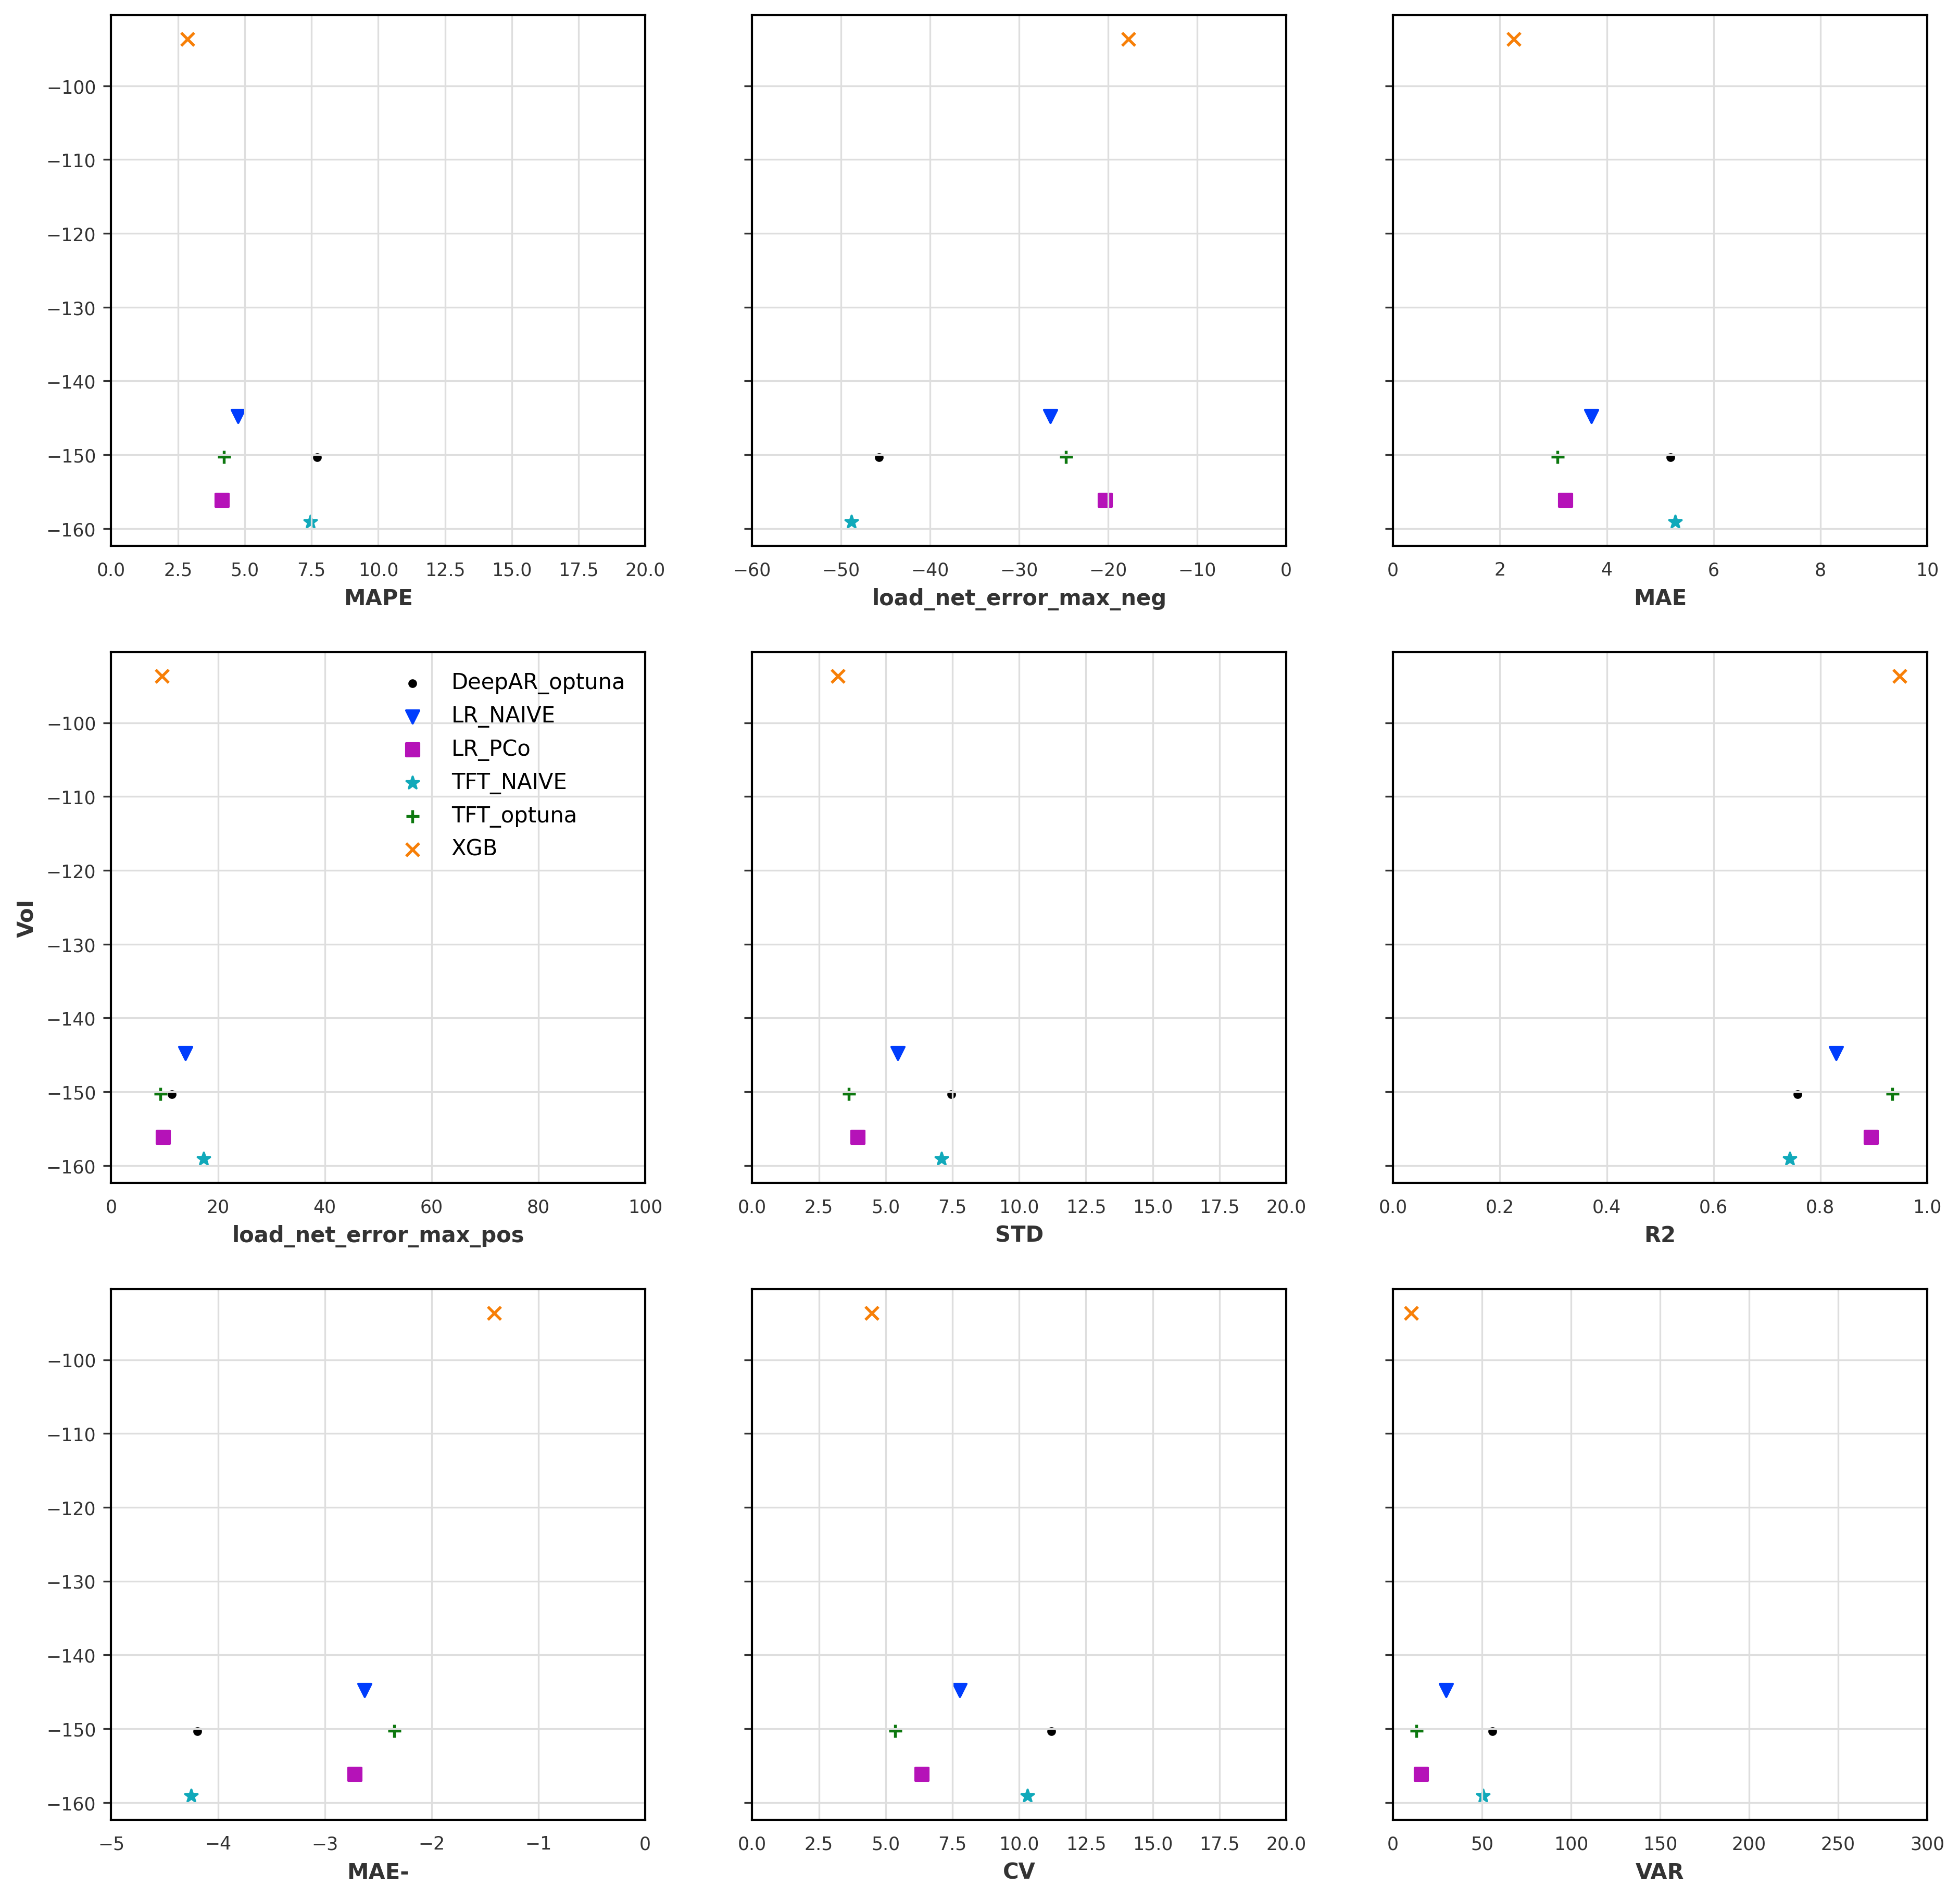

In [79]:
import matplotlib.pyplot as plt
#import numpy as np
#import matplotlib.gridspec as gridspec

'''fig = plt.figure(figsize=(18, 18))  # 创建画布
grid = gridspec.GridSpec(3, 3,width_ratios=[1,1,1],height_ratios=[1,1,1])  
grid.update(wspace =0.16, hspace = 0.18)'''

fig,axs=plt.subplots(3,3,figsize=(15,15),sharex=False,sharey=True)


method_dic=[
    "DeepAR_optuna",
    "LR_NAIVE",
    "LR_PCo",
    "TFT_NAIVE",
    "TFT_optuna",
    "XGB"
]

marker_dic={
    "DeepAR_optuna":'.',
    "LR_NAIVE":'v',
    "LR_PCo":'s',
    "TFT_NAIVE":'*',
    "TFT_optuna":'+',
    "XGB":'x',
    'load_net_error_max_neg':'o',
    'load_net_error_max_pos':'o',
}
xlimit={
    'CV':[0,20],
    'MAE':[0,10],
    'MAE+':[0,5],
    'MAE-':[-5,0],
    'MAPE':[0,20],
    'OPE':[0,10],
    'RMSE':[0,20],
    'STD':[0,20],
    'VAR':[0,300],
    'MSE':[0,20],
    'MARRE':[0,15],
    'R2':[0,1],
    'SMAPE':[0,15],
    'load_net_error_max_neg':[-60,0],
    'load_net_error_max_pos':[0,100],
}

metrics_keys={
    'CV',
    'MAE',
    'MAPE',
    #'OPE',
    'VAR',
    'MAE-',
    #'RMSE',
    'STD',
    #'MSE',
    #'MARRE',
    'R2',
    #'SMAPE',
    'load_net_error_max_neg',
    'load_net_error_max_pos',
}

total_df_0dc=total_df[(total_df.price_dc==0) & (total_df.month_of_year==4)]
total_df_dc=total_df[(total_df.price_dc==0.6) & (total_df.month_of_year==4)]

#total_df_0dc=total_df[(total_df.price_dc==0) ]
#total_df_dc=total_df[(total_df.price_dc==0.6) ]

df_to_plot=total_df_dc
key_to_plot='VoI'
i,j=0,0
for metric in metrics_keys:
    ax=axs[i,j] # 第二行，第3列

    for method in method_dic:
        X=df_to_plot[df_to_plot.pred_method==method][metric]
        Y=df_to_plot[df_to_plot.pred_method==method][key_to_plot]
        ax.scatter(X,Y,label=method,marker=marker_dic[method])
        ax.set_xlim(xlimit[metric])
    
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.set_xlabel(metric)
    if i==1 and j==0:
        ax.set_ylabel(key_to_plot)
        ax.legend()
    if i<2:
        i+=1
    else:
        i=0
        j+=1
        
#plt.suptitle(0.5,0.85,"Metrics and relative_OPEX (dc=0)",)

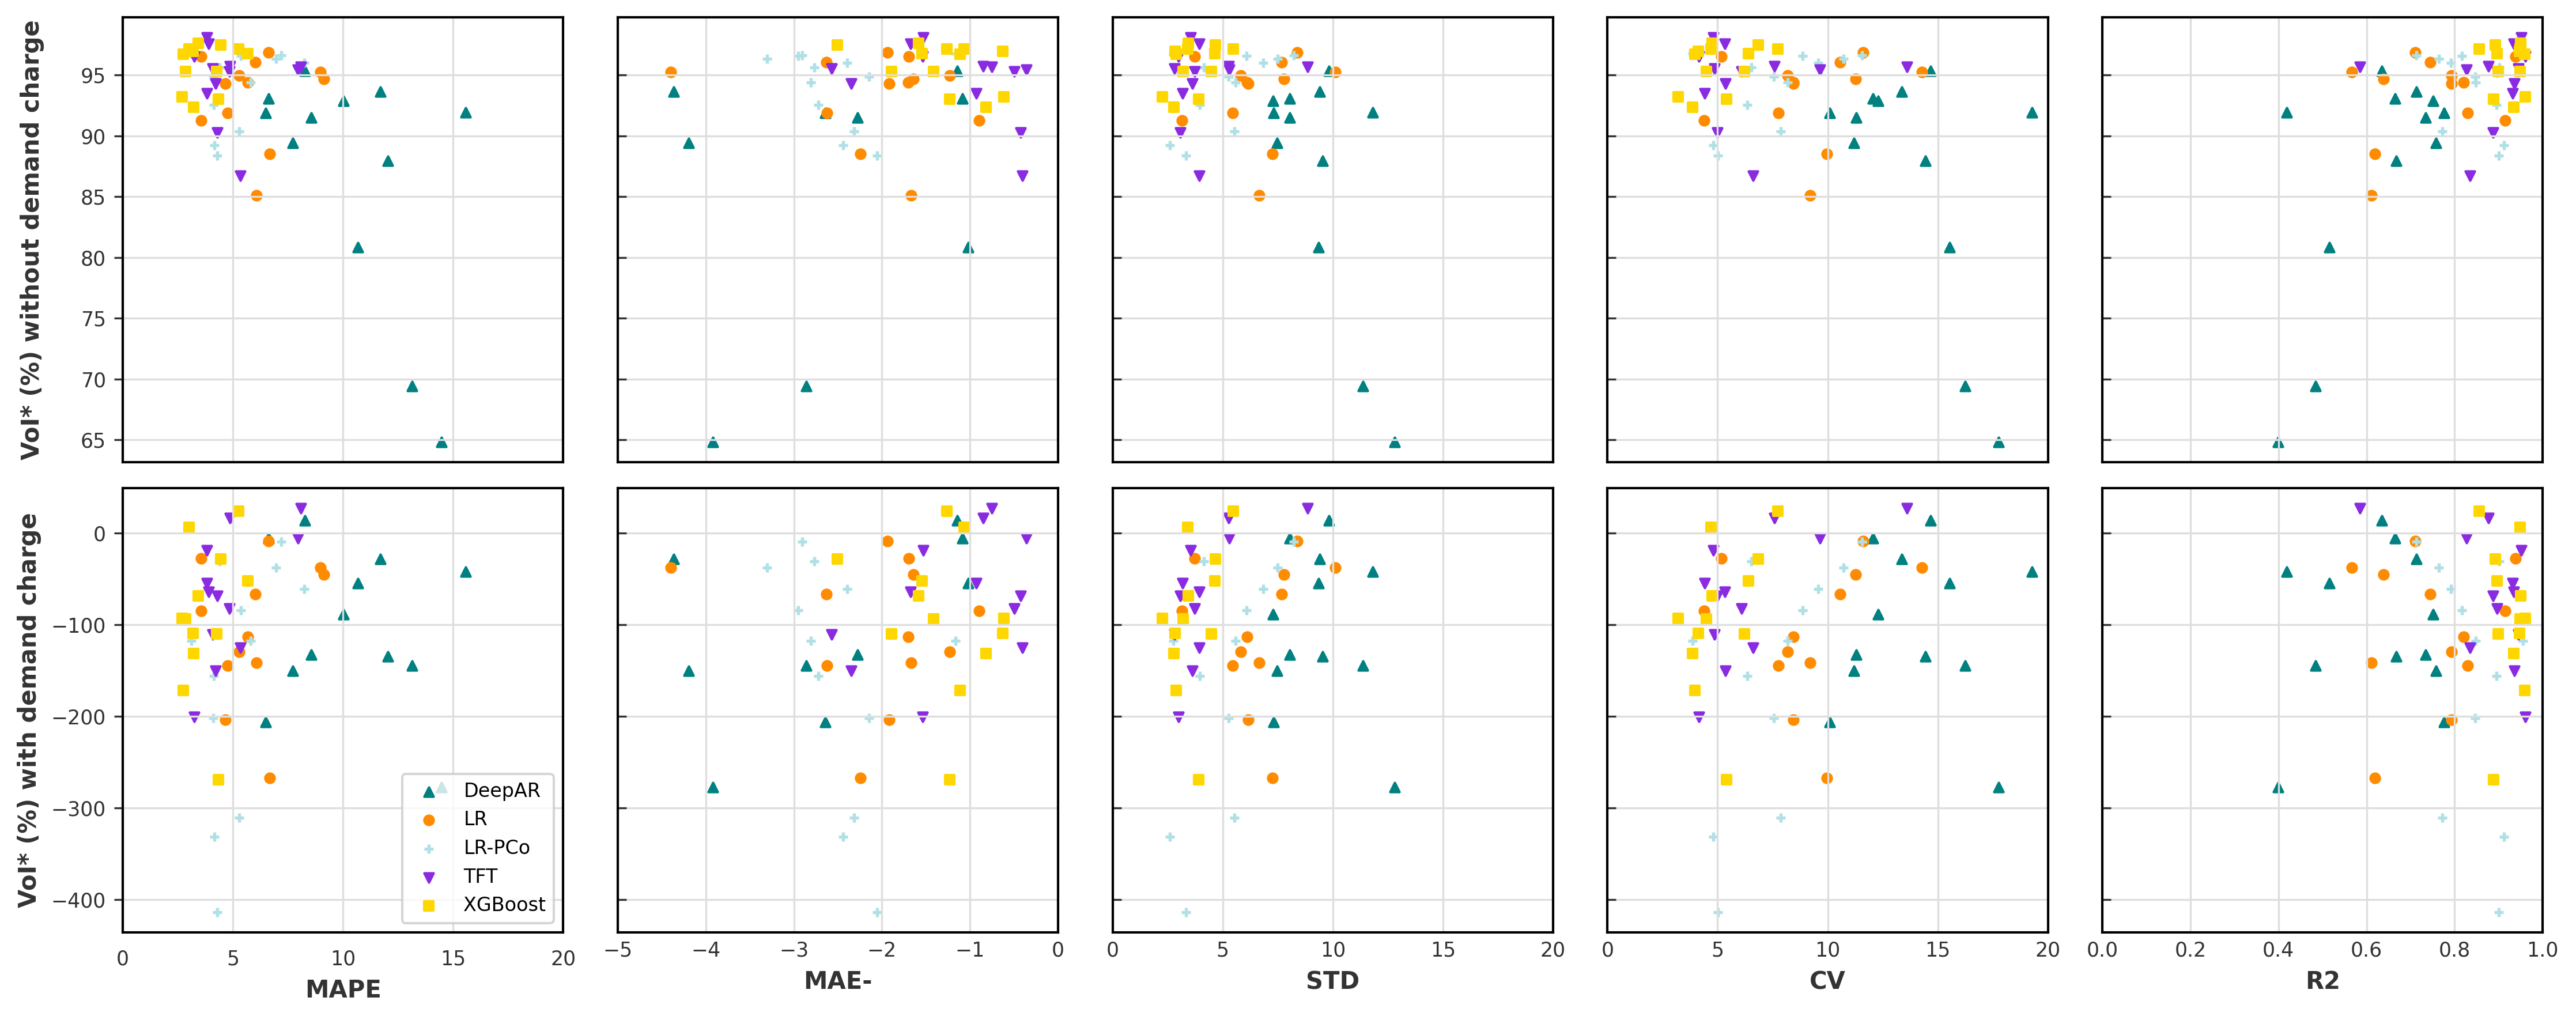

In [130]:
import matplotlib.pyplot as plt
#import numpy as np
#import matplotlib.gridspec as gridspec

'''fig = plt.figure(figsize=(18, 18))  # 创建画布
grid = gridspec.GridSpec(3, 3,width_ratios=[1,1,1],height_ratios=[1,1,1])  
grid.update(wspace =0.16, hspace = 0.18)'''

fig,axs=plt.subplots(2,5,figsize=(15,6),sharex=False,sharey=False)


method_dic=[
    "DeepAR_optuna",
    "LR_NAIVE",
    "LR_PCo",
    #"TFT_NAIVE",
    "TFT_optuna",
    "XGB"
]

color_dic={
    "DeepAR_optuna":'teal',
    "LR_NAIVE":'darkorange',
    "LR_PCo":'powderblue',
    #"TFT_NAIVE":'*',
    "TFT_optuna":'blueviolet',
    "XGB":'gold'
}

label_dic={
    "DeepAR_optuna":'DeepAR',
    "LR_NAIVE":'LR',
    "LR_PCo":'LR-PCo',
    #"TFT_NAIVE":'*',
    "TFT_optuna":'TFT',
    "XGB":'XGBoost'
}
marker_dic={
    "DeepAR_optuna":'^',
    "LR_NAIVE":'o',
    "LR_PCo":'+',
    "TFT_optuna":'v',
    "XGB":'s',
}
xlimit={
    'CV':[0,20],
    'MAE':[0,10],
    'MAE+':[0,5],
    'MAE-':[-5,0],
    'MAPE':[0,20],
    'OPE':[0,10],
    'RMSE':[0,20],
    'STD':[0,20],
    'VAR':[0,300],
    'MSE':[0,20],
    'MARRE':[0,15],
    'R2':[0,1],
    'SMAPE':[0,15],
    'load_net_error_max_neg':[-60,0],
    'load_net_error_max_pos':[0,100],
}

metrics_keys={
    'CV',
    #'MAE',
    'MAPE',
    #'OPE',
    #'VAR',
    'MAE-',
    #'RMSE',
    'STD',
    #'MSE',
    #'MARRE',
    'R2',
    #'SMAPE',
    #'load_net_error_max_neg',
    #'load_net_error_max_pos',
}

total_df_0dc=total_df[(total_df.price_dc==0) & (total_df.month_of_year==4)]
total_df_dc=total_df[(total_df.price_dc==0.6) & (total_df.month_of_year==4)]

total_df_0dc=total_df[(total_df.price_dc==0) ]
total_df_dc=total_df[(total_df.price_dc==0.6) ]

#########################################################################################################
df_to_plot=total_df_0dc
key_to_plot='VoI'
i,j=0,0
for metric in metrics_keys:
    ax=axs[0,i] # 第二行，第3列

    for method in method_dic:
        X=df_to_plot[df_to_plot.pred_method==method][metric]
        Y=df_to_plot[df_to_plot.pred_method==method][key_to_plot]
        ax.scatter(X,Y,marker=marker_dic[method],color=color_dic[method],label=label_dic[method],s=15)
        ax.set_xlim(xlimit[metric])
    
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    #ax.set_xlabel(metric,weight='regular')
    if i==0 :
        ax.set_ylabel('VoI* (%) without demand charge',weight='semibold',labelpad=15)
        #ax.legend(fontsize=8,loc='lower right',facecolor='w',frameon=True)
    else:
        ax.set_yticklabels([])
        ax.tick_params(direction='in',axis='both')
    ax.set_xticklabels([])
    i+=1
    if i>=5:
        break
#########################################################################################################  
    
df_to_plot=total_df_dc
key_to_plot='VoI'
i,j=0,0
for metric in metrics_keys:
    ax=axs[1,i] # 第二行，第3列

    for method in method_dic:
        X=df_to_plot[df_to_plot.pred_method==method][metric]
        Y=df_to_plot[df_to_plot.pred_method==method][key_to_plot]
        ax.scatter(X,Y,marker=marker_dic[method],color=color_dic[method],label=label_dic[method],s=15)
        ax.set_xlim(xlimit[metric])
    
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.set_xlabel(metric,weight='semibold')
    if i==0 :
        ax.set_ylabel('VoI* (%) with demand charge',weight='semibold')
        ax.legend(fontsize=8,loc='lower right',facecolor='w',frameon=True)
    else:
        ax.set_yticklabels([])
        ax.tick_params(direction='in',axis='both')
    i+=1
    if i>=5:
        break
    
    
plt.tight_layout()

#plt.suptitle(0.5,0.85,"Metrics and relative_OPEX (dc=0)",)